### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [1]:
import numpy as np
import pandas as pd
import shap
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
import tensorflow as tf
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K 



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer



%matplotlib inline
class_names = ["Normal", "Corrupt", "Delay", "Loss", "Duplicate"]

seed = 0

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be importe

In [2]:
infile = open("../../tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)

### Read in a dataset file

In [3]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [4]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        row.append(val)    
    return row

### Clean data row
Not implemented

In [5]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

### Get dataset
Loads all files from a directory

In [6]:
packet_count_threshold = 200
def get_dataset(path1,path2 ="",path3 =""):
    path = path1+str(path2)+path3
    out_data = []
    file = open('summary.out', 'w')
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = np.nan_to_num(read_in_file(temp_path))
            rows_before = temp_data.shape[0]
            if rows_before == 0:
                continue
            temp_data = temp_data[temp_data[:,2] > packet_count_threshold]
            rows_after = temp_data.shape[0]
            print (path + " removed " + str(rows_before-rows_after) + "/" + str(rows_before) + " rows")
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    file.close
    return out_data

### Load all datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [27]:
A = ["50","100","200","400","500","600","800"]

emulab_normal = []
emulab_corrupt_001 = []
emulab_corrupt_005 = []
emulab_corrupt_01 = []
emulab_corrupt_05 = []

emulab_delay_1_1 = []
emulab_delay_5_2 = []
emulab_delay_10_5 = []
emulab_delay_25_20 = []

emulab_loss_001 = []
emulab_loss_005 = []
emulab_loss_01 = []
emulab_loss_05 =[]

emulab_duplicate_001 = []
emulab_duplicate_005 =[]
emulab_duplicate_01 = []
emulab_duplicate_05 = []


prefix = "../../DataSet/emulab/data/test";
emulab_normal = get_dataset(prefix,"20","/normal")
emulab_corrupt_001 = get_dataset(prefix,"20","/corrupt_0.01")
emulab_corrupt_005 = get_dataset(prefix,"20","/corrupt_0.05")
emulab_corrupt_01 = get_dataset(prefix,"20","/corrupt_0.1")
emulab_corrupt_05 = get_dataset(prefix,"20","/corrupt_0.5")

emulab_delay_1_1 = get_dataset(prefix,"20","/delay_1_var_1")
emulab_delay_5_2 = get_dataset(prefix,"20","/delay_5_var_2")
emulab_delay_10_5 = get_dataset(prefix,"20","/delay_100_var_20")
emulab_delay_25_20 = get_dataset(prefix,"20","/delay_25_var_20")

emulab_loss_001 = get_dataset(prefix,"20","/loss_0.01")
emulab_loss_005 = get_dataset(prefix,"20","/loss_0.05")
emulab_loss_01 = get_dataset(prefix,"20","/loss_0.1")
emulab_loss_05 = get_dataset(prefix,"20","/loss_0.5")

emulab_duplicate_001 = get_dataset(prefix,"20","/duplicate_0.01")
emulab_duplicate_005 = get_dataset(prefix,"20","/duplicate_0.05")
emulab_duplicate_01 = get_dataset(prefix,"20","/duplicate_0.1")
emulab_duplicate_05 = get_dataset(prefix,"20","/duplicate_0.5")

 

for a in A:
    emulab_normal = np.concatenate((emulab_normal,get_dataset(prefix,a,"/normal")))
    
    emulab_corrupt_001= np.concatenate((get_dataset(prefix,a,"/corrupt_0.01"),emulab_corrupt_001))
    emulab_corrupt_005= np.concatenate((get_dataset(prefix,a,"/corrupt_0.05"),emulab_corrupt_005))
    emulab_corrupt_01= np.concatenate((get_dataset(prefix,a,"/corrupt_0.1"),emulab_corrupt_01))
    emulab_corrupt_05= np.concatenate((get_dataset(prefix,a,"/corrupt_0.5"),emulab_corrupt_05))
                                 
    emulab_delay_1_1= np.concatenate((get_dataset(prefix,a,"/delay_1_var_1"),emulab_delay_1_1))
    emulab_delay_5_2= np.concatenate((get_dataset(prefix,a,"/delay_5_var_2"),emulab_delay_5_2))
    emulab_delay_10_5= np.concatenate((get_dataset(prefix,a,"/delay_100_var_20"),emulab_delay_10_5))
    emulab_delay_25_20= np.concatenate((get_dataset(prefix,a,"/delay_25_var_20"),emulab_delay_25_20))
    
    emulab_loss_001= np.concatenate((get_dataset(prefix,a,"/loss_0.01"),emulab_loss_001))
    emulab_loss_005= np.concatenate((get_dataset(prefix,a,"/loss_0.05"),emulab_loss_005))
    emulab_loss_01= np.concatenate((get_dataset(prefix,a,"/loss_0.1"),emulab_loss_01))
    emulab_loss_05= np.concatenate((get_dataset(prefix,a,"/loss_0.5"),emulab_loss_05))
    
    emulab_duplicate_001 = np.concatenate((get_dataset(prefix,a,"/duplicate_0.01"),emulab_duplicate_001))
    emulab_duplicate_005 = np.concatenate((get_dataset(prefix,a,"/duplicate_0.05"),emulab_duplicate_005))
    emulab_duplicate_01 = np.concatenate((get_dataset(prefix,a,"/duplicate_0.1"),emulab_duplicate_01))
    emulab_duplicate_05 = np.concatenate((get_dataset(prefix,a,"/duplicate_0.5"),emulab_duplicate_05))

    

l1  = np.ones(len(emulab_normal  ))    *1

l2  = np.ones(len(emulab_corrupt_001  ))   *2
l3  = np.ones(len(emulab_corrupt_005  ))   *2
l4  = np.ones(len(emulab_corrupt_01  ))   *2
l5  = np.ones(len(emulab_corrupt_05  ))   *2

l6  = np.ones(len(emulab_delay_1_1))   *3
l7  = np.ones(len(emulab_delay_5_2))   *3
l8  = np.ones(len(emulab_delay_10_5))  *3
l9  = np.ones(len(emulab_delay_25_20)) *3

l10  = np.ones(len(emulab_loss_001 ) )   *5
l11  = np.ones(len(emulab_loss_005 ) )   *5
l12  = np.ones(len(emulab_loss_01 ) )   *5
l13  = np.ones(len(emulab_loss_05))      *5

l14 = np.ones(len(emulab_duplicate_001 ) )    *4
l15  = np.ones(len(emulab_duplicate_005 ) )   *4
l16  = np.ones(len(emulab_duplicate_01 ) )   *4
l17  = np.ones(len(emulab_duplicate_05 ) )   *4


emulab_data = np.concatenate((emulab_normal,
    emulab_corrupt_001,
    emulab_corrupt_005,
    emulab_corrupt_01,
    emulab_corrupt_05,                
    emulab_delay_1_1,
    emulab_delay_5_2,
    emulab_delay_10_5,
    emulab_delay_25_20,
    emulab_loss_001,
    emulab_loss_005,
    emulab_loss_01,
    emulab_loss_05,
    emulab_duplicate_001,
    emulab_duplicate_005,
    emulab_duplicate_01,
    emulab_duplicate_05))


pandas_emulab = pd.DataFrame(data=emulab_data, 
              columns=data_field_labels)

emulab_data = PowerTransformer().fit_transform(pandas_emulab)


emulab_anom_type_data_labels = np.concatenate((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17))
emulab_anom_type_data_labels = pd.DataFrame(data=emulab_anom_type_data_labels)
emulab_anom_type_data_labels = emulab_anom_type_data_labels.values.ravel()



hpc_normal = get_dataset("../../DataSet/hpc/normal")
hpc_corr_01 = get_dataset("../../DataSet/hpc/corrupt_0.1perc")
hpc_corr_05 = get_dataset("../../DataSet/hpc/corrupt_0.5perc")
hpc_corr_10 = get_dataset("../../DataSet/hpc/corrupt_1.0perc")
hpc_delay_1_1 = get_dataset("../../DataSet/hpc/delay_1_var_1")
hpc_delay_5_2 = get_dataset("../../DataSet/hpc/delay_5_var_2")
hpc_delay_10_5 = get_dataset("../../DataSet/hpc/delay_10_var_5")
hpc_delay_25_20 = get_dataset("../../DataSet/hpc/delay_25_var_20")
hpc_drop_01 = get_dataset("../../DataSet/hpc/loss_5perc")
hpc_drop_001 = get_dataset("../../DataSet/hpc/loss_10perc")
hpc_drop_0005 = get_dataset("../../DataSet/hpc/loss_15perc")
hpc_dup_1 = get_dataset("../../DataSet/hpc/dup_10perc")
hpc_dup_2 = get_dataset("../../DataSet/hpc/dup_20perc")


hpc_corrupt_001 = get_dataset("../../DataSet/hpc/corrupt_0.01")
hpc_corrupt_005 = get_dataset("../../DataSet/hpc/corrupt_0.05")
hpc_corrupt_01 = get_dataset("../../DataSet/hpc/corrupt_0.1")
hpc_corrupt_05 = get_dataset("../../DataSet/hpc/corrupt_0.5")
hpc_duplicate_001 = get_dataset("../../DataSet/hpc/duplicate_0.01")
hpc_duplicate_005 = get_dataset("../../DataSet/hpc/duplicate_0.05")
hpc_duplicate_01 = get_dataset("../../DataSet/hpc/duplicate_0.1")
hpc_duplicate_05 = get_dataset("../../DataSet/hpc/duplicate_0.5")
hpc_loss_001 = get_dataset("../../DataSet/hpc/loss_0.01")
hpc_loss_005 = get_dataset("../../DataSet/hpc/loss_0.05")
hpc_loss_01 = get_dataset("../../DataSet/hpc/loss_0.1")
hpc_loss_05 = get_dataset("../../DataSet/hpc/loss_0.5")



hpc_l1  = np.ones(len(hpc_normal  ))    *1
hpc_l2  = np.ones(len(hpc_corr_01  ))   *2
hpc_l3  = np.ones(len(hpc_corr_05  ))   *2
hpc_l4  = np.ones(len(hpc_corr_10  ))   *2
hpc_l5  = np.ones(len(hpc_corrupt_001  ))   *2
hpc_l6  = np.ones(len(hpc_corrupt_005  ))   *2
hpc_l7  = np.ones(len(hpc_corrupt_01  ))   *2
hpc_l8  = np.ones(len(hpc_corrupt_05  ))   *2
hpc_l9  = np.ones(len(hpc_delay_1_1))   *3
hpc_l10  = np.ones(len(hpc_delay_5_2))   *3
hpc_l11  = np.ones(len(hpc_delay_10_5))  *3
hpc_l12  = np.ones(len(hpc_delay_25_20)) *3
hpc_l13  = np.ones(len(hpc_drop_01))     *4
hpc_l14  = np.ones(len(hpc_drop_001))    *4
hpc_l15  = np.ones(len(hpc_drop_0005))   *4
hpc_l16  = np.ones(len(hpc_loss_001))   *4
hpc_l17  = np.ones(len(hpc_loss_005))   *4
hpc_l18  = np.ones(len(hpc_loss_01))   *4
hpc_l19  = np.ones(len(hpc_loss_05))   *4
hpc_l20  = np.ones(len(hpc_dup_1))       *5
hpc_l21  = np.ones(len(hpc_dup_2))       *5
hpc_l22  = np.ones(len(hpc_duplicate_001))       *5
hpc_l23  = np.ones(len(hpc_duplicate_005))       *5
hpc_l24  = np.ones(len(hpc_duplicate_01))       *5
hpc_l25  = np.ones(len(hpc_duplicate_05))       *5

hpc_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_corrupt_001,hpc_corrupt_005,hpc_corrupt_01,hpc_corrupt_05,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_loss_001,hpc_loss_005,hpc_loss_01,hpc_loss_05,
                           hpc_dup_1, hpc_dup_2,hpc_duplicate_001,hpc_duplicate_005,hpc_duplicate_01,hpc_duplicate_05))

hpc_anom_type_data_labels = np.concatenate((hpc_l1, hpc_l2, hpc_l3, hpc_l4, hpc_l5, 
                                            hpc_l6, hpc_l7, hpc_l8, 
                                            hpc_l9, hpc_l10, hpc_l11, 
                                            hpc_l12, hpc_l13,hpc_l14, hpc_l15, hpc_l16, 
                                            hpc_l17, hpc_l18,hpc_l19,hpc_l20, 
                                            hpc_l21, hpc_l22,hpc_l23,hpc_l24,hpc_l25))

hpc_data = pd.DataFrame(data=hpc_data, 
              columns=data_field_labels)
hpc_data = PowerTransformer().fit_transform(hpc_data)
# hpc_data = MinMaxScaler().fit_transform(pandas_hpc)


hpc_anom_type_data_labels = pd.DataFrame(data=hpc_anom_type_data_labels)
hpc_anom_type_data_labels = hpc_anom_type_data_labels.values.ravel()


# print(pandas_hpc.shape)
# print(hpc_anom_type_data_labels.shape)

dtn_normal = get_dataset("../../DataSet/dtn/FINAL_DATA/normal")
dtn_normal2 = get_dataset("../../DataSet/dtn/DTN_LONG_DATA/normal")
dtn_corr_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc")
dtn_corr_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc")
dtn_corr_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc")
dtn_delay_1_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_1_var_1")
dtn_delay_5_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_5_var_2")
dtn_delay_10_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_10_var_5")
dtn_delay_25_20 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_25_var_20")
dtn_drop_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_1perc")
dtn_drop_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_5perc")
dtn_drop_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_10perc")
dtn_drop_15 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_15perc")
dtn_dup_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_0.1perc")
dtn_dup_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_1perc")
dtn_dup_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_2perc")

dtn_corrupt_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.01")
dtn_corrupt_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.05")
dtn_corrupt_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1")
dtn_corrupt_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5")
dtn_duplicate_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.01")
dtn_duplicate_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.05")
dtn_duplicate_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.1")
dtn_duplicate_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.5")
dtn_loss_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.01")
dtn_loss_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.05")
dtn_loss_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.1")
dtn_loss_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.5")


l1  = np.ones(len(dtn_normal  ) + len(dtn_normal2)) *1
l2  = np.ones(len(dtn_corr_01  ))   *2
l3  = np.ones(len(dtn_corr_05  ))   *2
l4  = np.ones(len(dtn_corr_10  ))   *2
l5  = np.ones(len(dtn_corrupt_001  ))  *2
l6  = np.ones(len(dtn_corrupt_005  ))  *2
l7  = np.ones(len(dtn_corrupt_01  ))   *2
l8  = np.ones(len(dtn_corrupt_05  ))   *2
l9  = np.ones(len(dtn_delay_1_1))   *3
l10  = np.ones(len(dtn_delay_5_2))   *3
l11  = np.ones(len(dtn_delay_10_5))  *3
l12  = np.ones(len(dtn_delay_25_20)) *3
l13  = np.ones(len(dtn_drop_01 ) ) *4
l14  = np.ones(len(dtn_drop_5) )   *4
l15  = np.ones(len(dtn_drop_10) )  *4
l16 = np.ones(len(dtn_drop_15) )   *4
l17  = np.ones(len(dtn_loss_001))  *4
l18  = np.ones(len(dtn_loss_005))  *4
l19  = np.ones(len(dtn_loss_01))   *4
l20  = np.ones(len(dtn_loss_05))   *4
l21  = np.ones(len(dtn_dup_01))    *5
l22  = np.ones(len(dtn_dup_1))     *5
l23  = np.ones(len(dtn_dup_2))     *5
l24  = np.ones(len(dtn_duplicate_001)) *5
l25  = np.ones(len(dtn_duplicate_005))*5
l26  = np.ones(len(dtn_duplicate_01)) *5
l27  = np.ones(len(dtn_duplicate_05)) *5




dtn_data = np.concatenate((dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10,
                           dtn_corrupt_001, dtn_corrupt_005, dtn_corrupt_01, dtn_corrupt_05, 
                           dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           dtn_drop_01, dtn_drop_5, dtn_drop_10, dtn_drop_15, dtn_loss_001,
                           dtn_loss_005, dtn_loss_01, dtn_loss_05,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2,dtn_duplicate_001,
                           dtn_duplicate_005, dtn_duplicate_01, dtn_duplicate_05))


# dtn_data = np.concatenate((dtn_normal, dtn_normal2,
#                            dtn_corrupt_001, dtn_corrupt_005, dtn_corrupt_01, dtn_corrupt_05, 
#                            dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20
#                            , dtn_loss_001,
#                            dtn_loss_005, dtn_loss_01, dtn_loss_05,                          
#                            dtn_duplicate_001,
#                            dtn_duplicate_005, dtn_duplicate_01, dtn_duplicate_05))
print("###########")
print(data_field_labels)
print("###########")
dtn_data = pd.DataFrame(data=dtn_data, 
              columns=data_field_labels)
dtn_data = PowerTransformer().fit_transform(dtn_data)
# dtn_data = MinMaxScaler().fit_transform(pandas_dtn)



dtn_anom_type_data_labels = np.concatenate((l1,l2,l3,l4, l5, l6, l7, l8, l9, l10, l11, l12,l13,l14,l15,l16,l17, l18, l19, l20,l21,l22,l23,l24,l25,l26,l27))
dtn_anom_type_data_labels = pd.DataFrame(data=dtn_anom_type_data_labels)
dtn_anom_type_data_labels = dtn_anom_type_data_labels.values.ravel()


# print(pandas_dtn.shape)
# print(dtn_anom_type_data_labels.shape)



../../DataSet/emulab/data/test20/normal removed 119/238 rows
../../DataSet/emulab/data/test20/normal removed 119/238 rows
../../DataSet/emulab/data/test20/normal removed 119/238 rows
../../DataSet/emulab/data/test20/corrupt_0.01 removed 118/236 rows
../../DataSet/emulab/data/test20/corrupt_0.05 removed 119/238 rows
../../DataSet/emulab/data/test20/corrupt_0.1 removed 119/236 rows
../../DataSet/emulab/data/test20/corrupt_0.5 removed 120/238 rows
../../DataSet/emulab/data/test20/delay_1_var_1 removed 119/232 rows
../../DataSet/emulab/data/test20/delay_5_var_2 removed 115/210 rows
../../DataSet/emulab/data/test20/delay_100_var_20 removed 118/193 rows
../../DataSet/emulab/data/test20/delay_25_var_20 removed 118/188 rows
../../DataSet/emulab/data/test20/loss_0.01 removed 119/238 rows
../../DataSet/emulab/data/test20/loss_0.05 removed 119/238 rows
../../DataSet/emulab/data/test20/loss_0.1 removed 119/238 rows
../../DataSet/emulab/data/test20/loss_0.5 removed 119/237 rows


elementwise comparison failed; this will raise an error in the future.


../../DataSet/emulab/data/test20/duplicate_0.01 removed 119/238 rows
../../DataSet/emulab/data/test20/duplicate_0.05 removed 119/238 rows
../../DataSet/emulab/data/test20/duplicate_0.1 removed 119/238 rows
../../DataSet/emulab/data/test20/duplicate_0.5 removed 119/238 rows
../../DataSet/emulab/data/test50/normal removed 119/238 rows
../../DataSet/emulab/data/test50/normal removed 119/238 rows
../../DataSet/emulab/data/test50/normal removed 119/238 rows
../../DataSet/emulab/data/test50/corrupt_0.01 removed 119/238 rows
../../DataSet/emulab/data/test50/corrupt_0.05 removed 119/238 rows
../../DataSet/emulab/data/test50/corrupt_0.1 removed 119/237 rows
../../DataSet/emulab/data/test50/corrupt_0.5 removed 119/238 rows
../../DataSet/emulab/data/test50/delay_1_var_1 removed 118/234 rows
../../DataSet/emulab/data/test50/delay_5_var_2 removed 116/211 rows
../../DataSet/emulab/data/test50/delay_100_var_20 removed 119/192 rows
../../DataSet/emulab/data/test50/delay_25_var_20 removed 119/193 rows


../../DataSet/emulab/data/test800/delay_1_var_1 removed 115/215 rows
../../DataSet/emulab/data/test800/delay_5_var_2 removed 112/194 rows
../../DataSet/emulab/data/test800/delay_100_var_20 removed 108/177 rows
../../DataSet/emulab/data/test800/delay_25_var_20 removed 109/180 rows
../../DataSet/emulab/data/test800/loss_0.01 removed 119/239 rows
../../DataSet/emulab/data/test800/loss_0.05 removed 119/238 rows
../../DataSet/emulab/data/test800/loss_0.1 removed 119/239 rows
../../DataSet/emulab/data/test800/loss_0.5 removed 119/238 rows
../../DataSet/emulab/data/test800/duplicate_0.01 removed 119/239 rows
../../DataSet/emulab/data/test800/duplicate_0.05 removed 119/239 rows
../../DataSet/emulab/data/test800/duplicate_0.1 removed 119/239 rows
../../DataSet/emulab/data/test800/duplicate_0.5 removed 119/239 rows


divide by zero encountered in log
overflow encountered in multiply
overflow encountered in reduce


../../DataSet/hpc/normal removed 1076/1430 rows
../../DataSet/hpc/normal removed 1078/1432 rows
../../DataSet/hpc/normal removed 428/441 rows
../../DataSet/hpc/corrupt_0.1perc removed 1064/1416 rows
../../DataSet/hpc/corrupt_0.1perc removed 359/370 rows


elementwise comparison failed; this will raise an error in the future.


../../DataSet/hpc/corrupt_0.1perc removed 1072/1425 rows
../../DataSet/hpc/corrupt_0.5perc removed 1069/1413 rows
../../DataSet/hpc/corrupt_0.5perc removed 1083/1436 rows
../../DataSet/hpc/corrupt_0.5perc removed 436/436 rows
../../DataSet/hpc/corrupt_1.0perc removed 1143/1483 rows
../../DataSet/hpc/corrupt_1.0perc removed 1092/1445 rows
../../DataSet/hpc/corrupt_1.0perc removed 856/1054 rows
../../DataSet/hpc/corrupt_1.0perc removed 1007/1329 rows
../../DataSet/hpc/delay_1_var_1 removed 636/798 rows
../../DataSet/hpc/delay_1_var_1 removed 1270/1590 rows
../../DataSet/hpc/delay_5_var_2 removed 860/1103 rows
../../DataSet/hpc/delay_5_var_2 removed 1202/1552 rows
../../DataSet/hpc/delay_10_var_5 removed 596/763 rows
../../DataSet/hpc/delay_10_var_5 removed 1430/1793 rows
../../DataSet/hpc/delay_25_var_20 removed 582/717 rows
../../DataSet/hpc/delay_25_var_20 removed 1421/1769 rows
../../DataSet/hpc/loss_5perc removed 9/9 rows
../../DataSet/hpc/loss_5perc removed 2/2 rows
../../DataSet/hp

overflow encountered in power
overflow encountered in multiply
overflow encountered in reduce
divide by zero encountered in log


../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/FINAL_DATA/normal removed 120/240 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 353/706 rows


elementwise comparison failed; this will raise an error in the future.


../../DataSet/dtn/DTN_LONG_DATA/normal removed 354/708 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 354/708 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 18/36 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/delay_1_var_1 removed 7/13 rows
../../DataSet/dtn/FINAL_DATA/delay_1_var_1 removed 15/26 rows
../../DataSet/dtn/FINAL_DATA/delay_5_var_2 removed 10/18 rows
../../DataSet/dtn/FINAL_DATA/delay_5_var_2 removed 13/24 rows
../../DataSet/dtn/FINAL_DATA/delay_10_var_5 removed 14/25 rows
../../DataSet/dtn/FINAL_DATA/delay_10_var_5 removed 9/17 rows
../../DataSet/dtn/FINAL_DATA/delay_25_var_20 removed 4/7 rows
../.

divide by zero encountered in log
overflow encountered in multiply
overflow encountered in reduce


### Split Datasets (randomized on seed value)



In [28]:

# new_combine_date =  np.concatenate((dtn_data,emulab_data))
# new_combine_label =  np.concatenate((dtn_anom_type_data_labels,emulab_anom_type_data_labels))

# new_train_data, new_test_data, new_train_labels, new_test_labels = train_test_split(new_combine_date, 
#                                                                    new_combine_label, random_state=seed)
# new_train_data, new_train_labels = SMOTE().fit_resample(new_train_data, new_train_labels)


dtn_train_data, dtn_test_data, dtn_train_labels, dtn_test_labels = train_test_split(dtn_data, 
                                                                   dtn_anom_type_data_labels, random_state=seed)
dtn_train_data, dtn_train_labels = SMOTE().fit_resample(dtn_train_data, dtn_train_labels)

emulab_train_data, emulab_test_data, emulab_train_labels, emulab_test_labels = train_test_split(emulab_data, emulab_anom_type_data_labels
                                                                    , random_state=seed)
emulab_train_data, emulab_train_labels = SMOTE().fit_resample(emulab_train_data, emulab_train_labels)

hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, random_state=seed)
hpc_train_data, hpc_train_labels = SMOTE().fit_resample(hpc_train_data, hpc_train_labels)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_index

## NN :

Train on 5696 samples, validate on 1424 samples
Epoch 1/10
5696/5696 [==============================] - 1s 233us/sample - loss: 0.1567 - accuracy: 0.9519 - val_loss: 0.0237 - val_accuracy: 0.9930
Epoch 2/10
5696/5696 [==============================] - 0s 68us/sample - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.0119 - val_accuracy: 0.9979
Epoch 3/10
5696/5696 [==============================] - 0s 66us/sample - loss: 0.0191 - accuracy: 0.9946 - val_loss: 3.6458e-04 - val_accuracy: 1.0000
Epoch 4/10
5696/5696 [==============================] - 0s 68us/sample - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/10
5696/5696 [==============================] - 0s 68us/sample - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 6/10
5696/5696 [==============================] - 0s 66us/sample - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0042 - val_accuracy: 1.0000


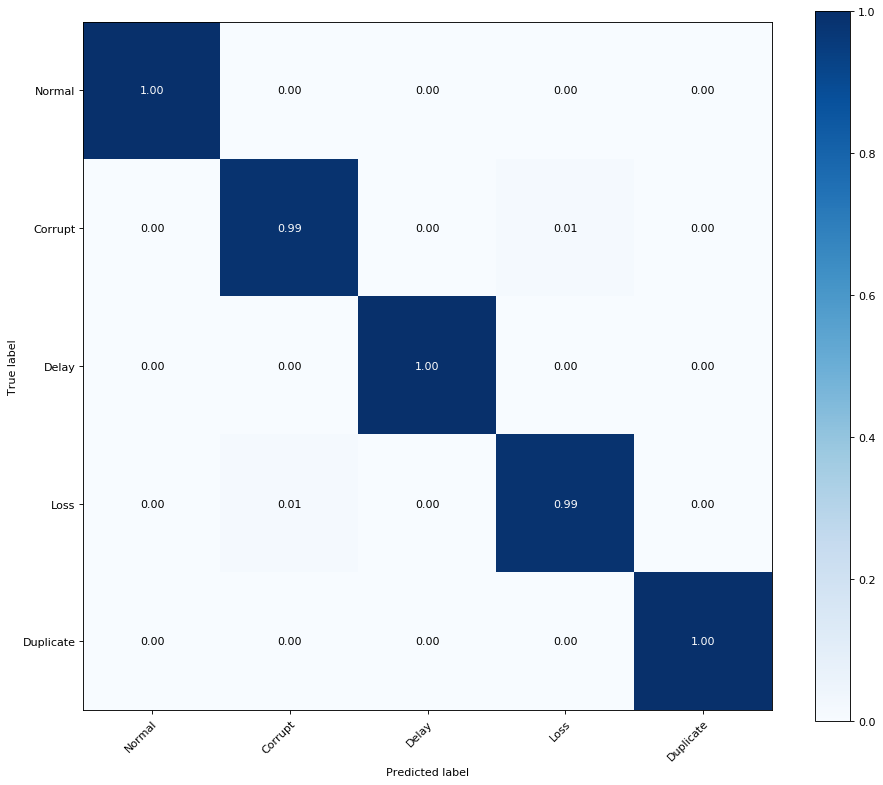

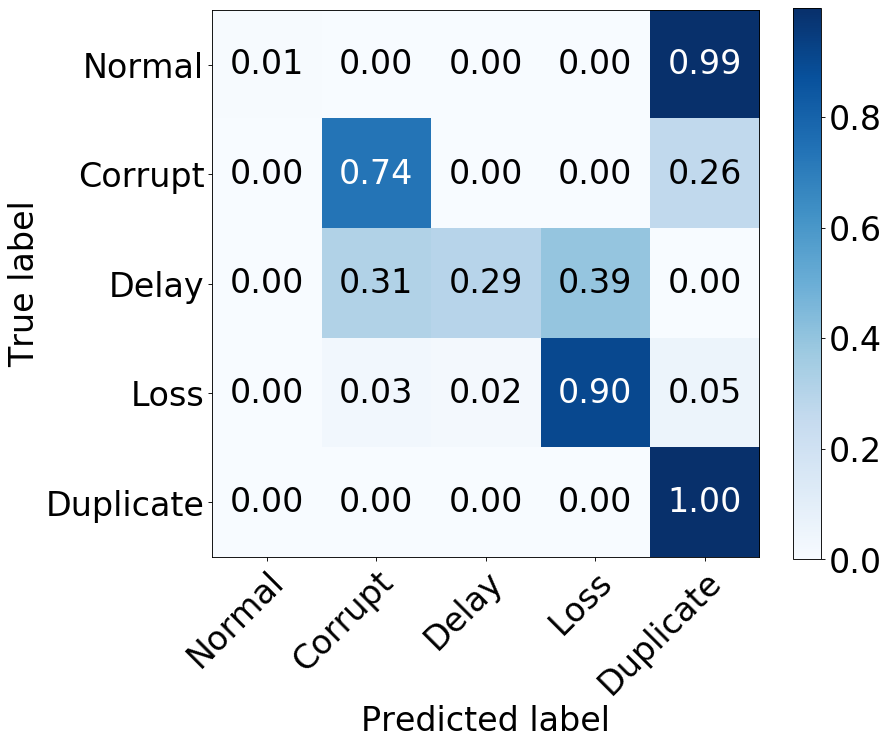

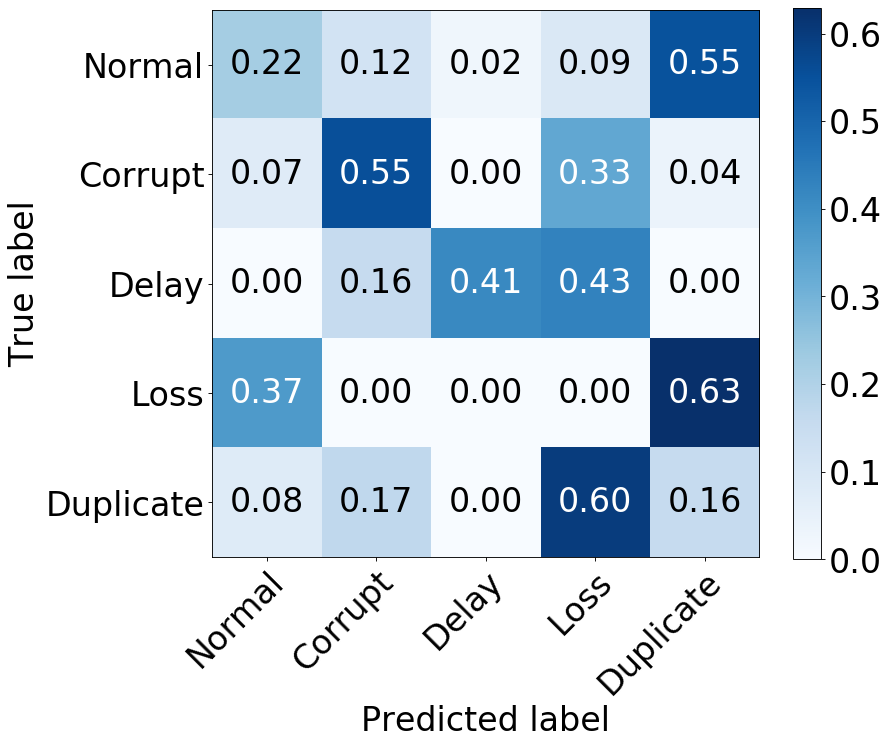

Train on 27388 samples, validate on 6847 samples
Epoch 1/10
27388/27388 [==============================] - 3s 110us/sample - loss: 0.0954 - accuracy: 0.9702 - val_loss: 0.0324 - val_accuracy: 0.9797
Epoch 2/10
27388/27388 [==============================] - 2s 81us/sample - loss: 0.0507 - accuracy: 0.9799 - val_loss: 0.0578 - val_accuracy: 0.9758
Epoch 3/10
27388/27388 [==============================] - 2s 74us/sample - loss: 0.0498 - accuracy: 0.9801 - val_loss: 0.0310 - val_accuracy: 0.9997
Epoch 4/10
27388/27388 [==============================] - 2s 70us/sample - loss: 0.0462 - accuracy: 0.9805 - val_loss: 0.0243 - val_accuracy: 0.9999
Epoch 5/10
27388/27388 [==============================] - 2s 68us/sample - loss: 0.0474 - accuracy: 0.9803 - val_loss: 0.0291 - val_accuracy: 0.9999
Epoch 6/10
27388/27388 [==============================] - 2s 71us/sample - loss: 0.0437 - accuracy: 0.9805 - val_loss: 0.0464 - val_accuracy: 0.9772
Epoch 7/10
27388/27388 [==============================] 

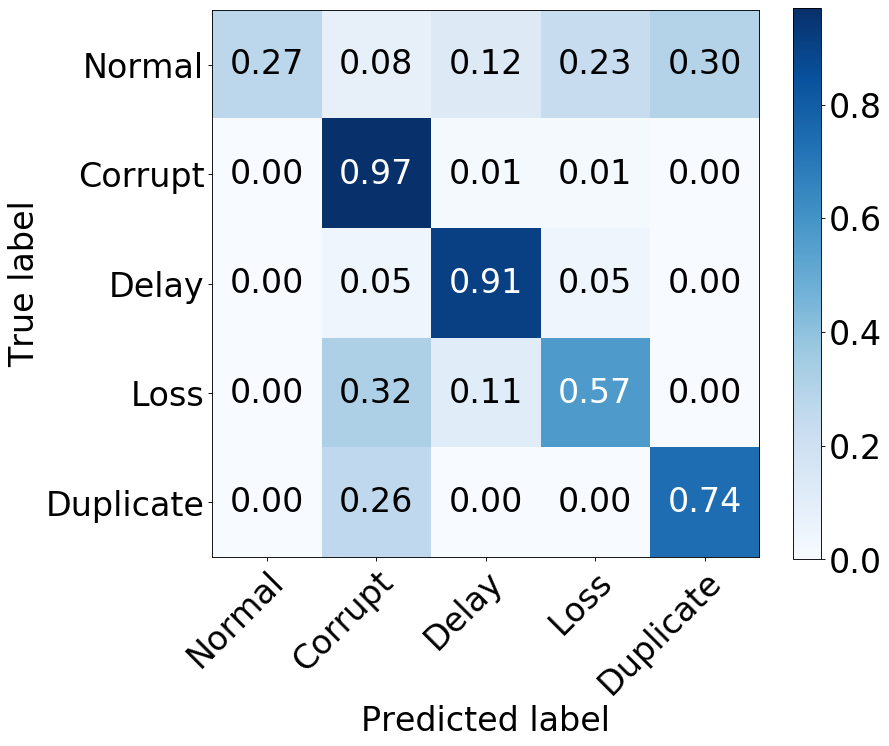

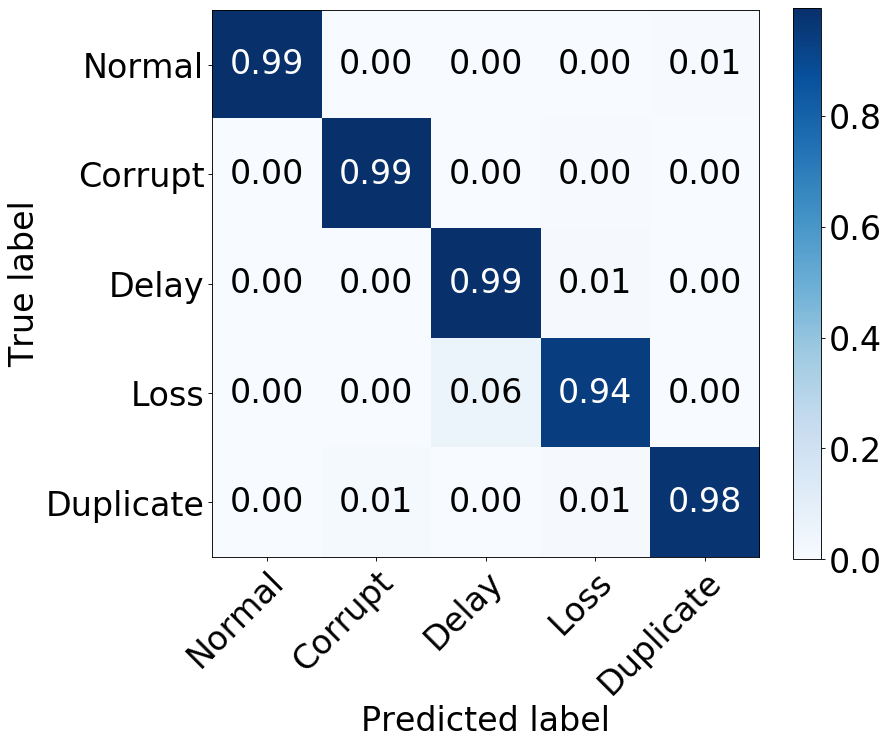

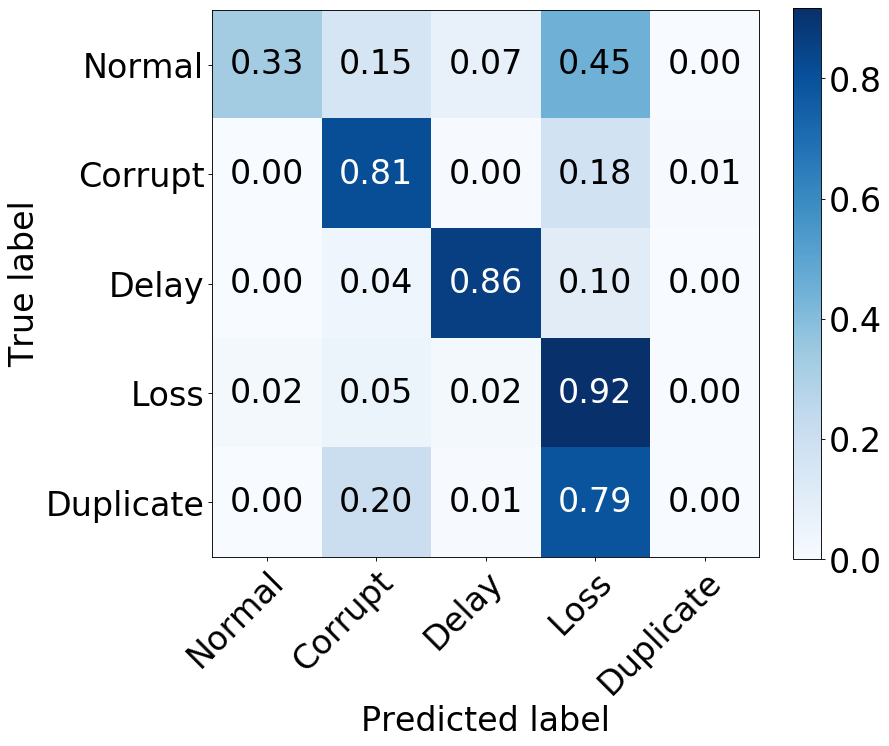

Train on 14604 samples, validate on 3651 samples
Epoch 1/10
14604/14604 [==============================] - 2s 137us/sample - loss: 0.3821 - accuracy: 0.8553 - val_loss: 0.1061 - val_accuracy: 0.9460
Epoch 2/10
14604/14604 [==============================] - 1s 78us/sample - loss: 0.2247 - accuracy: 0.8982 - val_loss: 0.0642 - val_accuracy: 0.9721
Epoch 3/10
14604/14604 [==============================] - 1s 67us/sample - loss: 0.2005 - accuracy: 0.8998 - val_loss: 0.1109 - val_accuracy: 0.9921
Epoch 4/10
14604/14604 [==============================] - 1s 87us/sample - loss: 0.1976 - accuracy: 0.9001 - val_loss: 0.1024 - val_accuracy: 0.9444
Epoch 5/10
14604/14604 [==============================] - 1s 66us/sample - loss: 0.1874 - accuracy: 0.9015 - val_loss: 0.1056 - val_accuracy: 0.9430


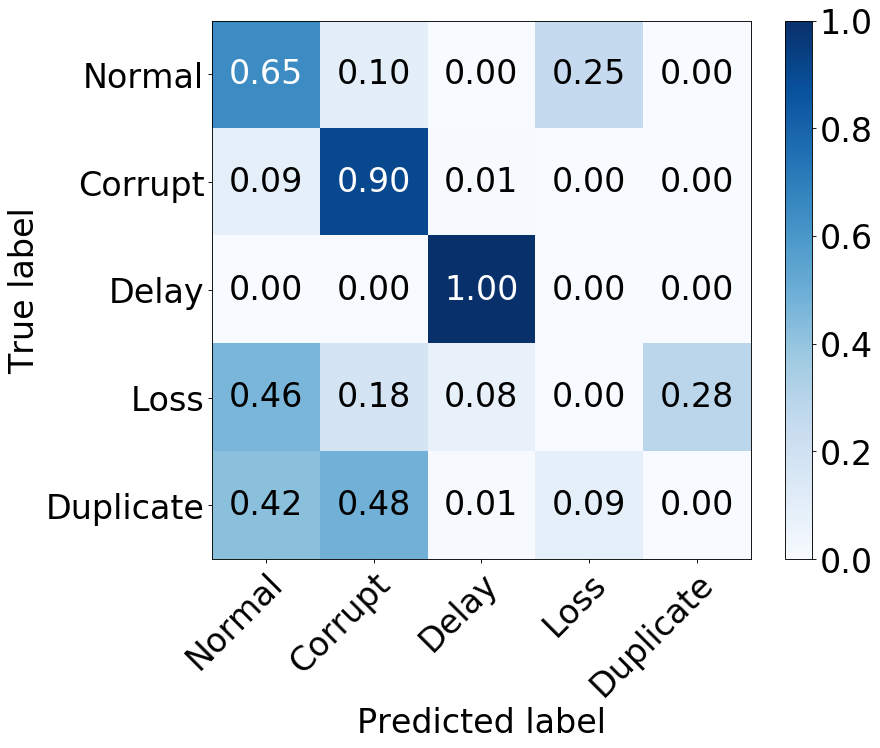

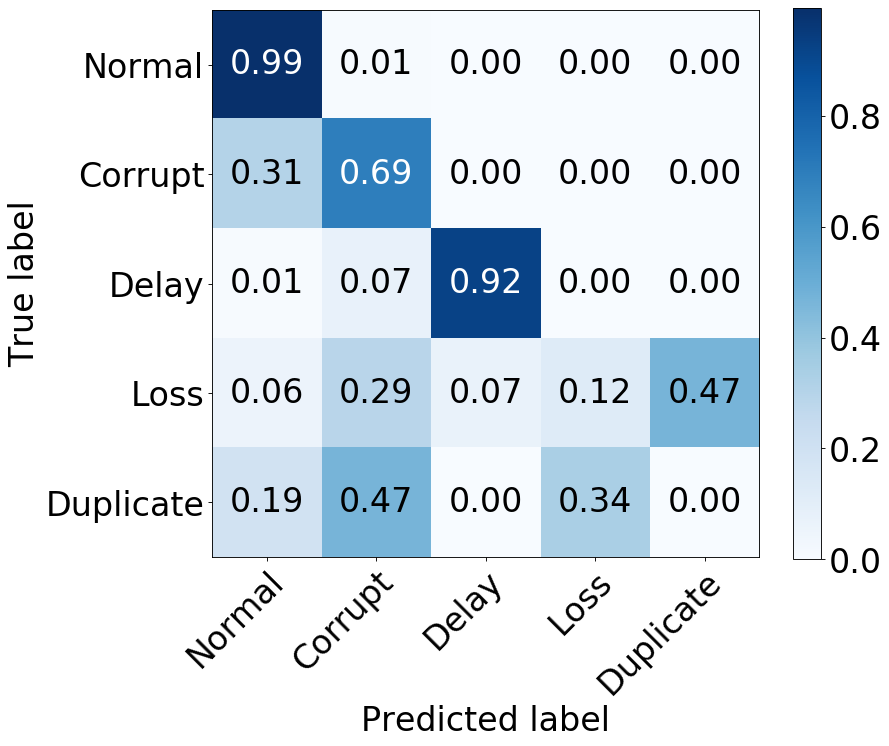

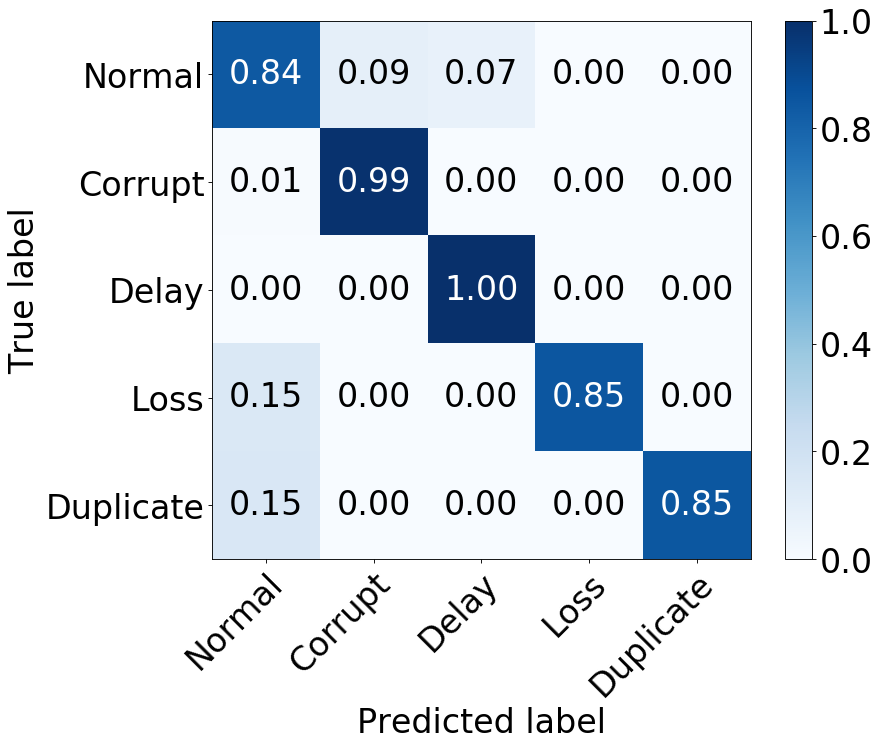

In [30]:
#create model
model = Sequential()

#get number of columns in training data
n_cols = dtn_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

dtn_train_labels = to_categorical(dtn_train_labels)
hpc_train_labels = to_categorical(hpc_train_labels)
emulab_train_labels = to_categorical(emulab_train_labels)



model.fit(dtn_train_data, dtn_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
plot_confusion_matrix(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_NN.pdf')
plt.show()
report = classification_report(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1), output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_NN_CR.csv", sep='\t')


hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1), output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_hpc_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_hpc_data_NN.pdf')
plt.show()

emulab_predicted_labels = model.predict(emulab_test_data)
report = classification_report(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1), output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_emulab_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_emulab_data_NN.pdf')
plt.show()


#create model
model = Sequential()

#get number of columns in training data
n_cols = dtn_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

#K.clear_session()
model.fit(hpc_train_data, hpc_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
report = classification_report(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_dtn_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_dtn_data_NN.pdf')
plt.show()

hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_NN.pdf')
plt.show()

emulab_predicted_labels = model.predict(emulab_test_data)
report = classification_report(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1), output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_emulab_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_emullab_data_NN.pdf')
plt.show()

#create model
model = Sequential()

#get number of columns in training data
n_cols = dtn_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

#K.clear_session()
model.fit(emulab_train_data, emulab_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
report = classification_report(dtn_test_labels,  np.argmax(dtn_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_dtn_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_dtn_data_NN.pdf')
plt.show()

hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1) , output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_hpc_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_hpc_data_NN.pdf')
plt.show()

emulab_predicted_labels = model.predict(emulab_test_data)
report = classification_report(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1) , output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_emulab_data_NN_CR.csv", sep='\t')
plot_confusion_matrix(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_emulab_data_NN.pdf')
plt.show()

In [ ]:

import shap
shap.initjs()

df_train_normed_summary = shap.kmeans(dtn_test_data[:200,:], 10)

explainer = shap.KernelExplainer(model.predict,df_train_normed_summary)
shap_values_dtn = explainer.shap_values(dtn_test_data[:200])


# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, dtn_train_data[:500])

# # explain the first 10 predictions
# # explaining each prediction requires 2 * background dataset size runs
# shap_values = explainer.shap_values(dtn_train_data[:500])

In [ ]:
dtn_test_data[:200][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1]

In [ ]:
shap.summary_plot(shap_values_dtn, dtn_test_data,feature_names = data_field_labels )
shap.summary_plot(shap_values_dtn[1], dtn_test_data[:200],plot_type = "dot",feature_names = data_field_labels)
shap.summary_plot(shap_values_dtn[5], dtn_test_data[:200],plot_type = "dot",feature_names = data_field_labels)



shap.summary_plot(shap_values_dtn[5][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1][:2], dtn_test_data[:200][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1][:2],plot_type = "dot",feature_names = data_field_labels)
print(model.predict(dtn_test_data[:200][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1][:2]).argmax(axis=1))
# print(dtn_test_data[:200][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1][:1]["c_avg_rrt"])
# dtn_test_data.iloc[:200][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1][:1]["c_avg_rrt"] = 1.4
# print(dtn_test_data[:200][(dtn_train_labels[:200] == 1).argmax(axis=1) == 1][:1]["c_avg_rrt"])


In [ ]:
dtn_test_data = pd.DataFrame(data=dtn_test_data, 
              columns=data_field_labels)
# print(dtn_test_data.iloc[17,:])
print(model.predict(dtn_test_data.iloc[12,:].values.reshape(1,89)).argmax(axis=1))
print(dtn_test_labels[12])
print(dtn_test_data.iloc[12]["c_pkts_push"])

print([(dtn_train_labels[:200] == 1).argmax(axis=1) == 1])



# print(model.predict().argmax(axis=1))


shap.force_plot(explainer.expected_value[5]
                , shap_values_dtn[5][12,:]
                , dtn_test_data.iloc[12,:], link="logit")

In [ ]:
df_train_normed_summary_emulab = shap.kmeans(emulab_train_data[:200,:], 10)

explainer_emulab = shap.KernelExplainer(model.predict,df_train_normed_summary_emulab)
shap_values = explainer_emulab.shap_values(emulab_train_data[:200,:])

In [ ]:
shap.summary_plot(shap_values, emulab_train_data[:200],feature_names = data_field_labels )
shap.summary_plot(shap_values[1], emulab_train_data[:200],plot_type = "dot",feature_names = data_field_labels)
shap.summary_plot(shap_values[5], emulab_train_data[:200],plot_type = "dot",feature_names = data_field_labels)



In [ ]:
# (emulab_train_labels == 1).argmax(axis=1) == 5
emulab_train_data = pd.DataFrame(data=emulab_train_data, 
              columns=data_field_labels)
dtn_train_data = pd.DataFrame(data=dtn_train_data, 
              columns=data_field_labels)

hpc_train_data = pd.DataFrame(data=hpc_train_data, 
              columns=data_field_labels)

print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 1]["c_pkts_ooo"].mean())
print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 5]["c_pkts_ooo"].mean())


print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 1]["c_pkts_ooo"].mean())
print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 5]["c_pkts_ooo"].mean())


print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 1]["c_pkts_ooo"].mean())
print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 5]["c_pkts_ooo"].mean())



print("##################################")


print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 1]["c_avg_rrt"].mean())
print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 5]["c_avg_rrt"].mean())


print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 1]["c_avg_rrt"].mean())
print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 5]["c_avg_rrt"].mean())


print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 1]["c_avg_rrt"].mean())
print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 5]["c_avg_rrt"].mean())




print("##################################")


print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 1]["c_pkt_reor"].mean())
print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 5]["c_pkt_reor"].mean())


print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 1]["c_pkt_reor"].mean())
print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 5]["c_pkt_reor"].mean())


print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 1]["c_pkt_reor"].mean())
print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 5]["c_pkt_reor"].mean())



print("##################################")


print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 1]["c_pkts_push"].mean())
print (emulab_train_data[(emulab_train_labels == 1).argmax(axis=1) == 5]["c_pkts_push"].mean())


print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 1]["c_pkts_push"].mean())
print (dtn_train_data[(dtn_train_labels == 1).argmax(axis=1) == 5]["c_pkts_push"].mean())


print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 1]["c_pkts_push"].mean())
print (hpc_train_data[(hpc_train_labels == 1).argmax(axis=1) == 5]["c_pkts_push"].mean())

In [ ]:
emulab_train_data = pd.DataFrame(data=emulab_train_data, 
              columns=data_field_labels)
print(model.predict(emulab_train_data.iloc[21,:].values.reshape(1,89)).argmax(axis=1))
print(emulab_train_labels[21])

shap.force_plot(explainer_emulab.expected_value[1]
                , shap_values[1][21,:]
                , emulab_train_data.iloc[21,:], link="logit")